In [40]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf
import keras
from keras import backend as K
from keras import regularizers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input
from tensorflow.keras.utils import load_img
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import  ReduceLROnPlateau
from keras.callbacks import  CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image







In [2]:
train_dir = "../data/train/" #path to the training images
test_dir  = "../data/test/"   #path to the  testing images

In [14]:
import os
NUM_EPOCHS = 60
IMG_SIZE = 48
BATCH_SIZE = 64


data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

def count_images(directory):
    count_dict = {}
    subfolders = os.listdir(directory)
    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            count = len(os.listdir(subfolder_path))
            count_dict[subfolder] = count
    return count_dict

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Train Counts:", train_counts)
print("Test Counts:", test_counts)

Train Counts: {'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}
Test Counts: {'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,  #scale image to 0 or 1
                                   #rotation_range = 25,
                                         #width_shift_range = 0.1,
                                         #height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         #vertical_flip=True,
                                         zoom_range = 0.2,
                                         fill_mode="nearest",
                                         validation_split = 0.2
                                        )

valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, vertical_flip=False)

In [16]:
training_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training", # set as training data
                                                     shuffle=True
                                                   )

test_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "validation", # set as validation data
                                                    shuffle=True
                                                   )

valid_set = valid_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (IMG_SIZE, IMG_SIZE),
                                                              batch_size = BATCH_SIZE,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle=True
                                                             )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
model = Sequential()

model.add(SeparableConv2D(32, kernel_size=(3,3), padding="same",  activation='relu', input_shape=(48, 48,1)))
model.add(SeparableConv2D(64, (3,3), padding="same",  activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(128, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(SeparableConv2D(256, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(512, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(SeparableConv2D(512, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 
model.add(Dense(1024, activation = 'relu'))
# model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax')) #facial expression have 7 classes

model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.0001, decay=1e-6),
    metrics=['accuracy']
  )

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_20 (Separa  (None, 48, 48, 32)       73        
 bleConv2D)                                                      
                                                                 
 separable_conv2d_21 (Separa  (None, 48, 48, 64)       2400      
 bleConv2D)                                                      
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 separable_conv2d_22 (Separa  (None, 24, 24, 128)     

In [29]:
chk_path = 'facial_expressions.h5'
log_dir = "checkpoint/log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [30]:
steps_per_epoch = training_set.samples // training_set.batch_size
valid_steps = valid_set.samples // valid_set.batch_size

history = model.fit_generator(training_set,
                 validation_data=valid_set,
                 epochs=NUM_EPOCHS,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=valid_steps,
                 callbacks=callbacks)

Epoch 1/5
358/358 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.3525
Epoch 1: val_loss improved from inf to 1.87496, saving model to facial_expressions.h5
358/358 [==============================] - 1365s 4s/step - loss: 1.7104 - accuracy: 0.3525 - val_loss: 1.8750 - val_accuracy: 0.2469 - lr: 1.0000e-04
Epoch 2/5
358/358 [==============================] - ETA: 0s - loss: 1.5218 - accuracy: 0.4308 
Epoch 2: val_loss improved from 1.87496 to 1.61880, saving model to facial_expressions.h5
358/358 [==============================] - 8067s 23s/step - loss: 1.5218 - accuracy: 0.4308 - val_loss: 1.6188 - val_accuracy: 0.3567 - lr: 1.0000e-04
Epoch 3/5
358/358 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.4601 
Epoch 3: val_loss improved from 1.61880 to 1.61744, saving model to facial_expressions.h5
358/358 [==============================] - 11477s 32s/step - loss: 1.4308 - accuracy: 0.4601 - val_loss: 1.6174 - val_accuracy: 0.3668 - lr: 1.000

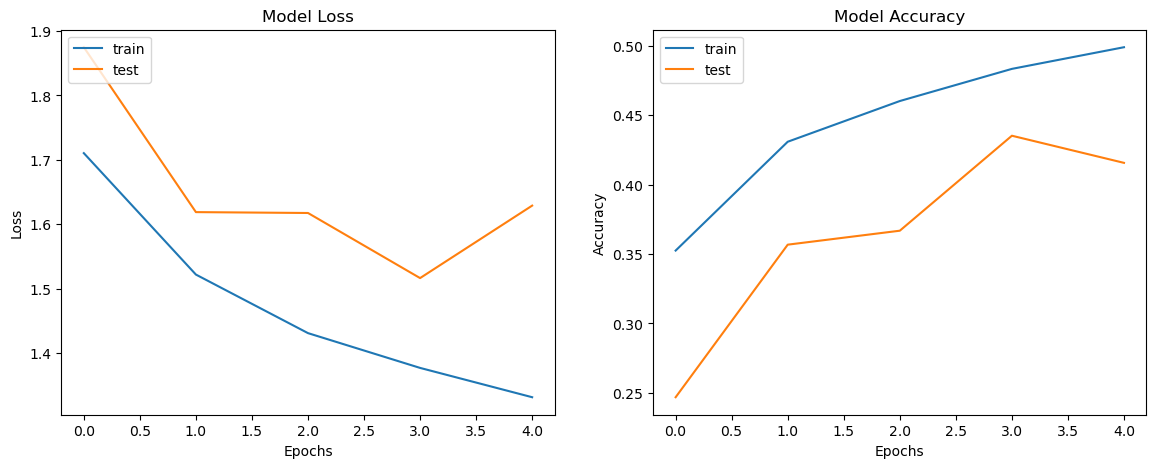

In [32]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])  # Updated line
plt.plot(history.history['val_accuracy'])  # Updated line
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [48]:
training_set.reset()
test_set.reset()

train_steps = training_set.samples // training_set.batch_size
test_steps = test_set.samples // test_set.batch_size

train_loss, train_acc = model.evaluate_generator(training_set, steps=train_steps)
test_loss, test_acc   = model.evaluate_generator(test_set, steps=test_steps)
print("final train accuracy = {:.2f} , testing accuracy = {:.2f}".format(train_acc*100, test_acc*100))

final train accuracy = 41.74 , testing accuracy = 40.38


In [34]:
model.save_weights('facial_expressions_bestweight.h5')

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = os.path.join(test_dir, 'happy', 'happy')

# Load image using PIL
img = Image.open(img_path).convert('L')  # Convert to grayscale

# Convert image to numpy array
img_array = np.array(img)

# Display the image
plt.imshow(img_array, cmap='gray')
plt.show()

# Print the shape of the image array
print(img_array.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'data\\test\\happy\\happy'

Confusion Matrix
[[ 527    0  287 1980   70   83  249]
 [  58    0   30  225    7   12   17]
 [ 542    0  307 2032   55   75  267]
 [ 929    0  541 3572  102  147  481]
 [ 685    0  406 2349   71   96  365]
 [ 682    0  339 2346   82   79  336]
 [ 445    0  213 1527   50   63  239]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15      3196
   disgusted       0.00      0.00      0.00       349
     fearful       0.14      0.09      0.11      3278
       happy       0.25      0.62      0.36      5772
     neutral       0.16      0.02      0.03      3972
         sad       0.14      0.02      0.04      3864
   surprised       0.12      0.09      0.11      2537

    accuracy                           0.21     22968
   macro avg       0.14      0.14      0.11     22968
weighted avg       0.17      0.21      0.15     22968



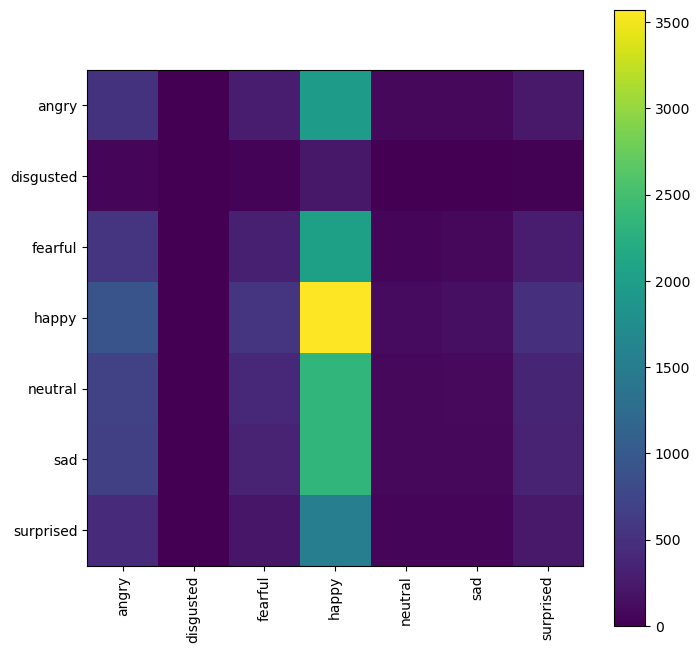

In [44]:
training_set.reset()
train_steps = (training_set.samples // training_set.batch_size)+1

y_pred = model.predict_generator(training_set, steps=train_steps)
y_pred = np.argmax(y_pred, axis=1)
class_labels = training_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[122   0  77 479  25  31  65]
 [ 10   0   5  61   1   2   8]
 [134   0  63 535  19  16  52]
 [234   0 154 891  18  33 113]
 [174   0  84 608  14  20  93]
 [159   0  66 623  18  18  82]
 [125   0  52 377  13  15  52]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.15      0.14       799
   disgusted       0.00      0.00      0.00        87
     fearful       0.13      0.08      0.10       819
       happy       0.25      0.62      0.36      1443
     neutral       0.13      0.01      0.03       993
         sad       0.13      0.02      0.03       966
   surprised       0.11      0.08      0.09       634

    accuracy                           0.20      5741
   macro avg       0.13      0.14      0.11      5741
weighted avg       0.16      0.20      0.14      5741



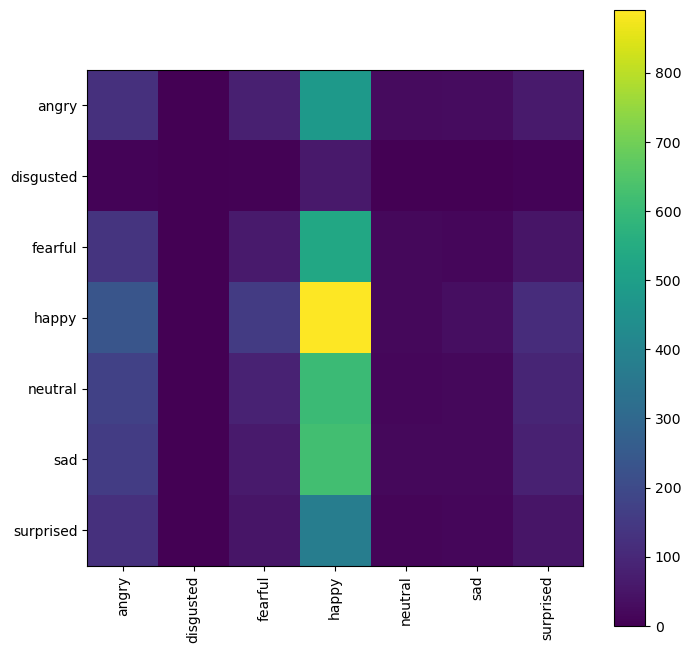

In [46]:
test_set.reset()
test_steps = (test_set.samples // test_set.batch_size)+1

y_pred = model.predict_generator(test_set, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)